In [1]:

from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import tensorflow as tf
tf.test.gpu_device_name()

Mounted at /content/drive


'/device:GPU:0'

In [2]:
#import packages

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sn
%matplotlib inline
import re
import sys
import warnings
import pandas as pd
import numpy as np
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import joblib

In [3]:
#needed for DNN 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from keras.regularizers import l2,l1
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
# from keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import models
from sklearn import preprocessing
from keras import layers
from tensorflow.keras.layers import LSTM,GRU,Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle

In [4]:
path = "/content/drive/MyDrive/Colab Notebooks/Suicide Ideation Detection using natural Language Processing"
df=pd.read_csv(path +  '/dataset/created/cleaned_df.csv', encoding='utf-8')
df =  shuffle(df).reset_index(drop=True)
df.head()


,text,label,cleaned_text
0,This isn’t me “over reacting” and shit. This i...,0,isnt react shit want right marry whoever want ...
1,i m really hungry but i can t find anything to...,0,really hungry find anything eat
2,your customer service is worthless and i’m no...,1,customer service worthless im sure ill shoppin...
3,@sabrinanetflix I really hope there is no sing...,0,really hope sing cant anymore riverdale americ...
4,I thought that I would die in my sleep but sad...,1,thought would die sleep sadly case


In [5]:
df.label.value_counts()

0    24720
1    24458
Name: label, dtype: int64

In [6]:
#split the data in train, validation, test

def dataset_split(headlines,category):

    X,X_test,y,y_test = train_test_split(headlines,category,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",len(headlines),
        "\n\tTraining\t\t",len(X_train),
        "\n\tTest\t\t\t",len(X_test),
        "\n\tValidation\t\t",len(X_valid))
  
    return X_train,X_valid,X_test,y_train,y_valid,y_test

In [7]:
df.clean_text=df.cleaned_text.astype(str)

X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(df.clean_text,df.label)


Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 49178 
	Training		 39834 
	Test			 4918 
	Validation		 4426


In [8]:
#define perameters for GRU and padding and tokenization
vocab_size =50000
embedding_dim = 64
max_length = 60
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [9]:
# Train Data Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train.values)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(X_train.values)
train_padded = pad_sequences(train_sequences,padding=padding_type, maxlen=max_length)

In [10]:
#Tokenizer Info
(word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
#insightful info about tokens
def tokenizer_info(mylist,bool):
  ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
  for w,c in ordered[:10]:
    print(w,"\t",c)

#Print all the information
print("Words --> Counts:")
tokenizer_info(word_counts,bool =True )
print("\nWords --> Documents:")
tokenizer_info(word_docs,bool =True )
print("\nWords --> Index:")
tokenizer_info(word_index,bool =True )    
print("\nTotal Documents -->",document_count)
print(f"Found {len(word_index)} unique tokens")

Words --> Counts:
want 	 19902
dont 	 11529
life 	 11410
go 	 10278
get 	 9471
like 	 9226
im 	 9054
know 	 7356
feel 	 7045
end 	 6766

Words --> Documents:
want 	 15179
life 	 8939
dont 	 8140
go 	 7482
im 	 7085
get 	 6692
like 	 6683
end 	 6003
live 	 5607
know 	 5289

Words --> Index:
kumamoto 	 35848
kinlush 	 35847
moreindetail 	 35846
kiddingi 	 35845
abysswho 	 35844
roti 	 35843
amstrong 	 35842
intermezzo 	 35841
sleuth 	 35840
omeara 	 35839

Total Documents --> 39834
Found 35848 unique tokens


In [11]:
def padded_headlines(original,encoded,padded):
  print("\n\t\t\t Encoded Sequences ","\n")  
  print(original,"\n",encoded) 
  print("\n\t\t\t Paded Sequences \n",original,"\n",padded)

padded_headlines(X_train[10],train_sequences[10],train_padded[10])


			 Encoded Sequences  

shaqiri play midfield interesting position see dont often play position maybe ball position get goal good pa amp good finish felt good amp want keep go im really happy 
 [20980, 33, 400, 67, 20981, 12471, 1374, 43, 128, 339, 128, 1439, 7, 12471, 2, 483, 1439, 2, 5, 4, 45, 675]

			 Paded Sequences 
 shaqiri play midfield interesting position see dont often play position maybe ball position get goal good pa amp good finish felt good amp want keep go im really happy 
 [20980    33   400    67 20981 12471  1374    43   128   339   128  1439
     7 12471     2   483  1439     2     5     4    45   675     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]


In [12]:
# Validation Data Tokenization
validation_sequences = tokenizer.texts_to_sequences(X_valid.values)
validation_padded = pad_sequences(validation_sequences,padding=padding_type, maxlen=max_length)
# padded_headlines(X_valid[47000],validation_sequences[47000],validation_padded[47000])


In [13]:
# Test Data Tokenization
test_sequences = tokenizer.texts_to_sequences(X_test.values)
test_padded = pad_sequences(test_sequences,padding=padding_type, maxlen=max_length)
#padded_headlines(X_test[35000],test_sequences[35000],test_padded[5000])


In [14]:
train_label_seq = y_train
valid_label_seq = y_valid
testing_label_seq = y_test

In [15]:
accuracy_threshold = 0.99
vocab_size = 50000
embedding_dim=128
max_length = 60
num_category = 2
opt=RMSprop(0.001)

In [16]:
keras.backend.clear_session()
#callback function for early stopping
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()

**Bidirectional GRU**

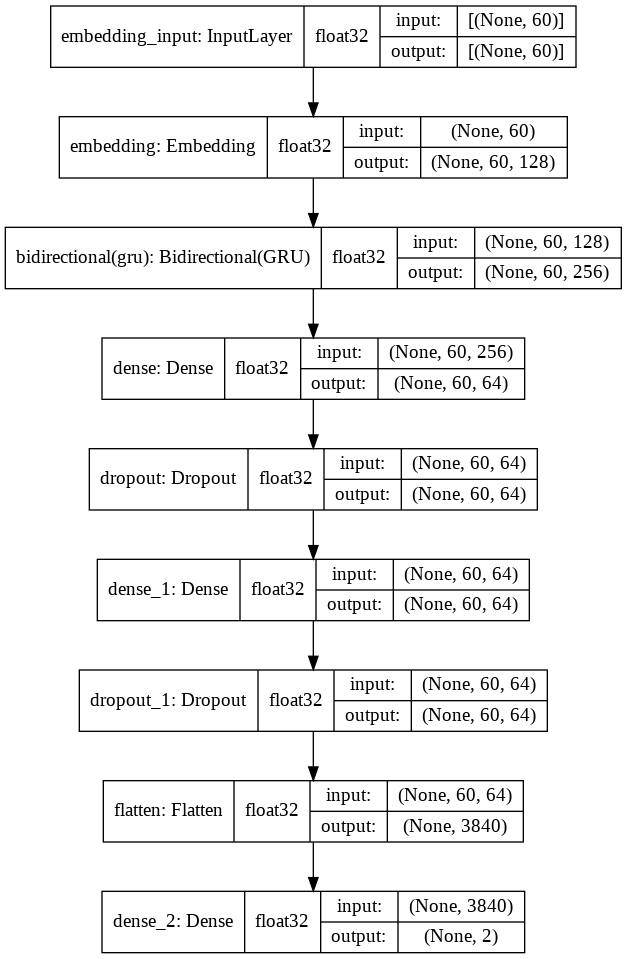

In [ ]:

filepath = path + "/model/BidGruModel.h5"

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.1, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.0001, cooldown=1, min_lr=0.000001)
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
callback_list = [acc_callback, checkpoint,reduceLROnPlat]
# checkpoint = ModelCheckpoint(s , monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = RMSprop(lr=1e-2, epsilon=1e-08)


BGRU_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]),
    tf.keras.layers.Bidirectional(GRU(128,return_sequences=True,dropout=0.2)),
    #tf.keras.layers.Bidirectional(GRU(64, dropout = 0.2, recurrent_dropout = 0.2)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_category, activation='softmax')
])

tf.keras.utils.plot_model(BGRU_model, to_file= path+ '/model/model structure/BGRUmodel.png',show_shapes=True,show_dtype=True)


In [ ]:
BGRU_model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
BGRU_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 128)           6400000   
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 256)           198144    
_________________________________________________________________
dense (Dense)                (None, 60, 64)            16448     
_________________________________________________________________
dropout (Dropout)            (None, 60, 64)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 60, 64)            4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3840)              0

In [ ]:
num_epochs = 20
batch = 128

BGRU_model_history = BGRU_model.fit(train_padded, train_label_seq, 
                    epochs=num_epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, valid_label_seq), 
                    verbose=1,
                    callbacks = callback_list)

Epoch 1/20
312/312 [==============================] - 21s 39ms/step - loss: 0.6929 - accuracy: 0.8144 - val_loss: 0.2692 - val_accuracy: 0.9099

Epoch 00001: val_accuracy improved from -inf to 0.90985, saving model to /content/drive/MyDrive/Colab Notebooks/Suicide Ideation Detection using natural Language Processing/model/BidGruModel.h5
Epoch 2/20
312/312 [==============================] - 11s 37ms/step - loss: 0.3453 - accuracy: 0.9198 - val_loss: 0.2166 - val_accuracy: 0.9216

Epoch 00002: val_accuracy improved from 0.90985 to 0.92160, saving model to /content/drive/MyDrive/Colab Notebooks/Suicide Ideation Detection using natural Language Processing/model/BidGruModel.h5
Epoch 3/20
312/312 [==============================] - 11s 37ms/step - loss: 0.2022 - accuracy: 0.9466 - val_loss: 0.1967 - val_accuracy: 0.9315

Epoch 00003: val_accuracy improved from 0.92160 to 0.93154, saving model to /content/drive/MyDrive/Colab Notebooks/Suicide Ideation Detection using natural Language Processin

In [17]:
sn.set_style('whitegrid')

In [18]:
# Plot training results
def model_evaluate(history,directory,filename):
  H = history.history
  fig = plt.figure(figsize = (30, 8))
  plt.subplot(121)
  plt.xlabel("number of epoch")
  plt.ylabel("accuracy")
  plt.plot(H['accuracy'], label = 'training accuracy', marker='o')
  plt.plot(H['val_accuracy'], label = 'val accuracy',marker='o')
  plt.xticks( rotation=0, weight = 'bold', )
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend()
  # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),prop={'size': 15},
  #         fancybox=True, shadow=True, ncol=5)
  plt.subplot(122)
  plt.xlabel("number of epoch")
  plt.ylabel("loss")
  plt.plot(H['loss'], label = 'training loss',marker='o')
  plt.plot(H['val_loss'], label = 'val loss',marker='o')
  plt.xticks( rotation=0, weight = 'bold', )
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend()
  plt.savefig(path + "/model/"+directory+"/"+filename+".png")


In [19]:
# Plot all model results
def model_all_evaluate(history1,history2,history3,history4,directory,filename):
  H1 = history1.history
  H2 = history2.history
  H3 = history3.history
  H4 = history4.history
  fig = plt.figure(figsize = (30, 8))
  plt.subplot(121)
  plt.title('Comparing DL models validation accuracy \n')
  plt.xlabel("number of epoch")
  plt.ylabel("accuracy")
  plt.plot(H1['val_accuracy'], label = 'BiGRU',marker='o')
  plt.plot(H2['val_accuracy'], label = 'BiLSTM',marker='o')
  plt.plot(H3['val_accuracy'], label = 'LSTM',marker='o')
  plt.plot(H4['val_accuracy'], label = 'C_LSTM',marker='o')
  plt.xticks( rotation=0, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend()

  plt.subplot(122)
  plt.title('Comparing DL models validation loss \n')
  plt.xlabel("number of epoch")
  plt.ylabel("Validation loss")
  plt.plot(H1['val_loss'], label = 'BiGRU',marker='o')
  plt.plot(H2['val_loss'], label = 'BiLSTM',marker='o')
  plt.plot(H3['val_loss'], label = 'LSTM',marker='o')
  plt.plot(H4['val_loss'], label = 'C_LSTM',marker='o')
  plt.xticks( rotation=0, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend()
  plt.savefig(path + "/model/" +directory+ "/" +filename+ ".png")


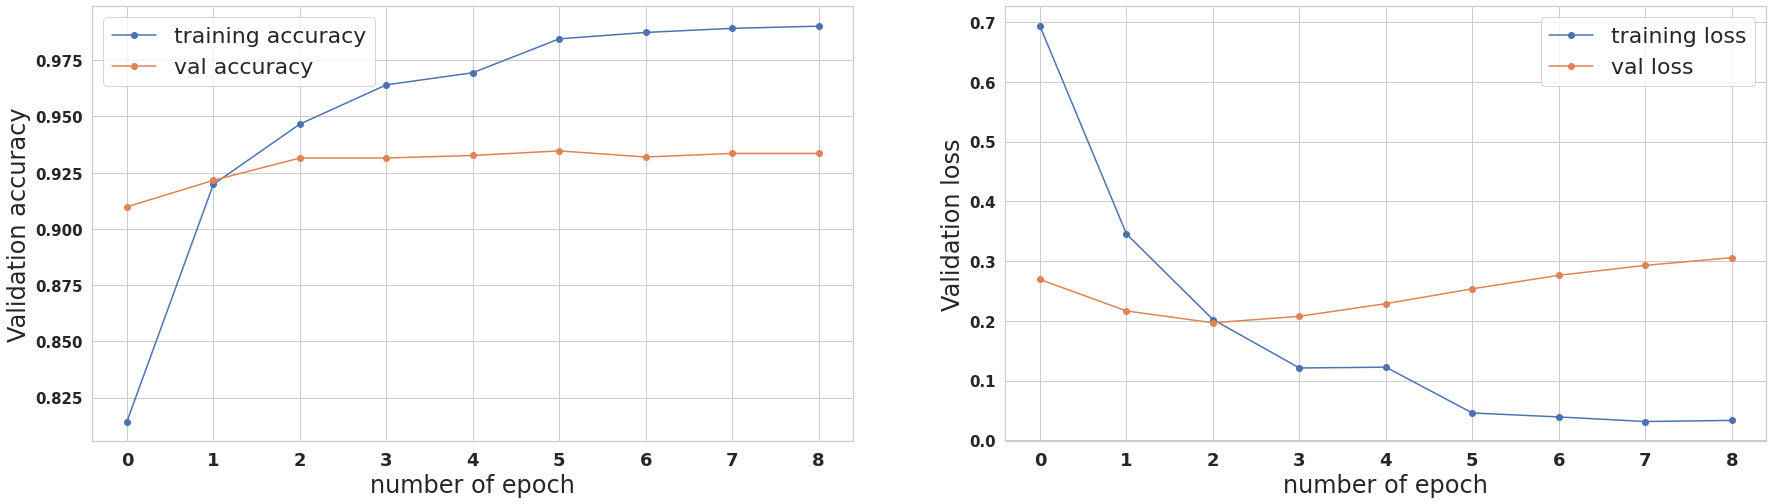

In [ ]:
model_evaluate(BGRU_model_history,"BiGru","Bi_Gru_evaluation")

In [ ]:
#confusion matrix
def conf_matrix(y_pred,classfier,directory,filename, figsize=(8,8)):
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d' % (p, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=['non-suicidal', 'suicidal'], columns=['non-suicidal', 'suicidal'])
    sn.set(font_scale=2) # Adjust to fit
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sn.heatmap(cm, cmap= "magma", annot=annot, fmt='', ax=ax)
    plt.title('\n''Confusion Matrix: '+classfier+'\n')
    plt.ylabel('True label',fontsize=18)
    plt.xlabel('Predicted label',fontsize=18)
    plt.xticks( rotation=0, weight = 'bold')
    plt.yticks( rotation=90, weight = 'bold')
    plt.savefig(path + "/model/"+directory+"/"+filename+".png")
    plt.show()
    plt.close()

In [ ]:
#make predictions

model = load_model(path+"/model/BidGruModel.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)


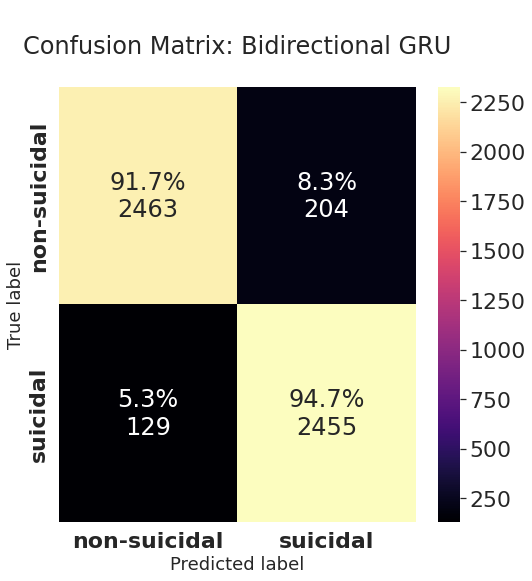

In [ ]:
conf_matrix(y_pred,"Bidirectional GRU","BiGru","Bi_Gru_confusion_matrix")

**Bidirectional LSTM**

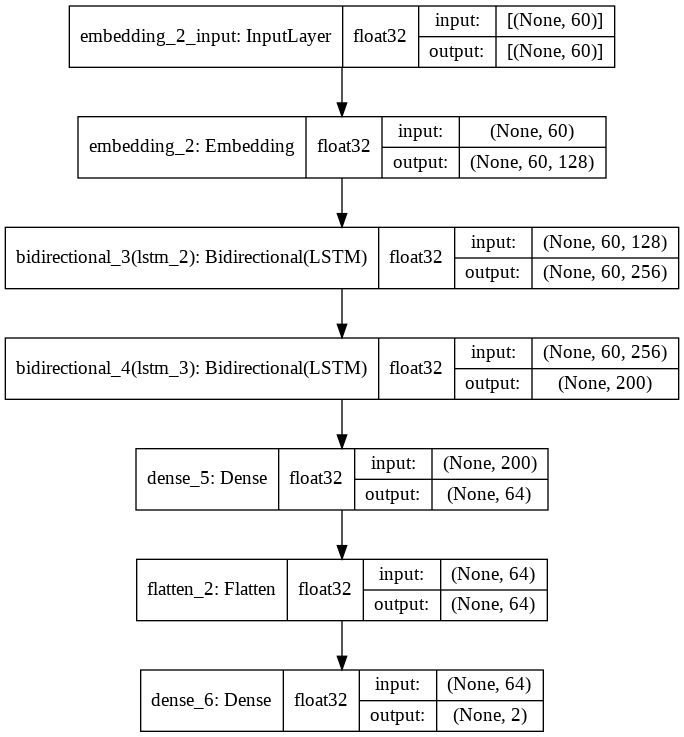

In [ ]:
embedding_dim=128
filepath = path+"/model/BiLSTM.h5"
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.1, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.0001, cooldown=1, min_lr=0.000001)
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
callback_list = [acc_callback, checkpoint,reduceLROnPlat]
RNN_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]),
    tf.keras.layers.Bidirectional(LSTM(128,dropout = 0.2, recurrent_dropout = 0.2,return_sequences=True)),
    tf.keras.layers.Bidirectional(LSTM(100, dropout = 0.2, recurrent_dropout = 0.2)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_category, activation='softmax')
])
tf.keras.utils.plot_model(RNN_model, to_file= path+ '/model/model structure/BiLSTMmodel.png', show_shapes=True, show_dtype=True,)


In [ ]:
RNN_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(RNN_model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 128)           6400000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 60, 256)           263168    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               285600    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                12864     
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
Total params: 6,961,762
Trainable params: 6,961,762
Non-trainable params: 0
____________________________________________

In [ ]:
num_epochs = 20
batch = 128

RNN_history = RNN_model.fit(train_padded, train_label_seq, 
                    epochs=num_epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, valid_label_seq), 
                    verbose=1,
                    callbacks = callback_list)



Epoch 1/20
312/312 [==============================] - 554s 2s/step - loss: 0.3075 - accuracy: 0.8698 - val_loss: 0.2609 - val_accuracy: 0.9004

Epoch 00001: val_accuracy improved from -inf to 0.90036, saving model to /content/drive/MyDrive/Colab Notebooks/Suicide Ideation Detection using natural Language Processing/model/BiLSTM.h5
Epoch 2/20
312/312 [==============================] - 502s 2s/step - loss: 0.1792 - accuracy: 0.9395 - val_loss: 0.2282 - val_accuracy: 0.9164

Epoch 00002: val_accuracy improved from 0.90036 to 0.91640, saving model to /content/drive/MyDrive/Colab Notebooks/Suicide Ideation Detection using natural Language Processing/model/BiLSTM.h5
Epoch 3/20
312/312 [==============================] - 517s 2s/step - loss: 0.1379 - accuracy: 0.9540 - val_loss: 0.2087 - val_accuracy: 0.9207

Epoch 00003: val_accuracy improved from 0.91640 to 0.92070, saving model to /content/drive/MyDrive/Colab Notebooks/Suicide Ideation Detection using natural Language Processing/model/BiLST

In [ ]:
#make predictions

RNN_model = load_model(path+"/model/BiLSTM.h5")
RNN_predictions = RNN_model.predict(test_padded)
y_pred = np.argmax(RNN_predictions, axis=1)

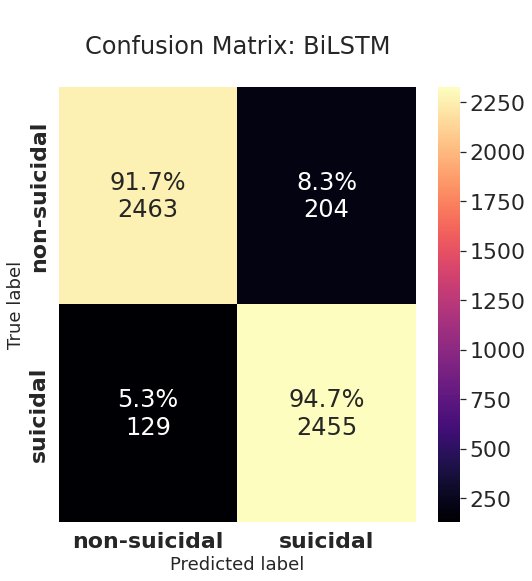

In [ ]:
conf_matrix(y_pred,"BiLSTM","BiLSTM","BiLSTM_confusion_matrix")

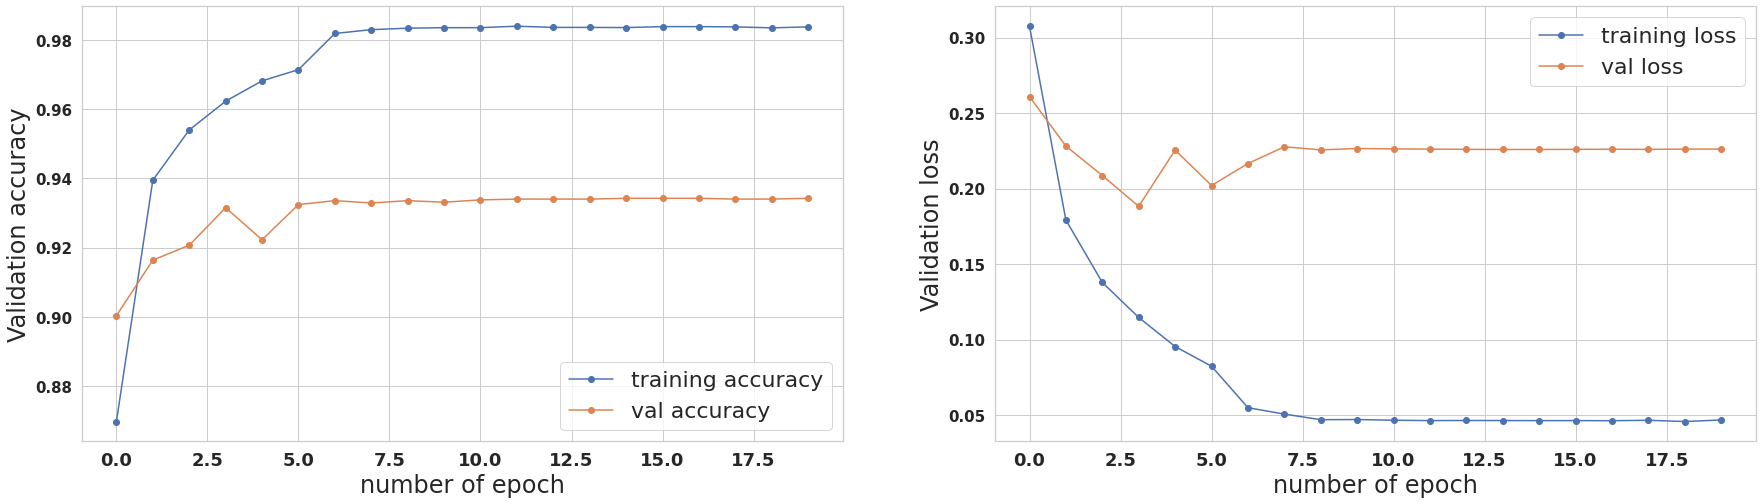

In [ ]:
# Plot training results
model_evaluate(RNN_history,"BiLSTM","BiLSTM_evaluation")


**LSTM**

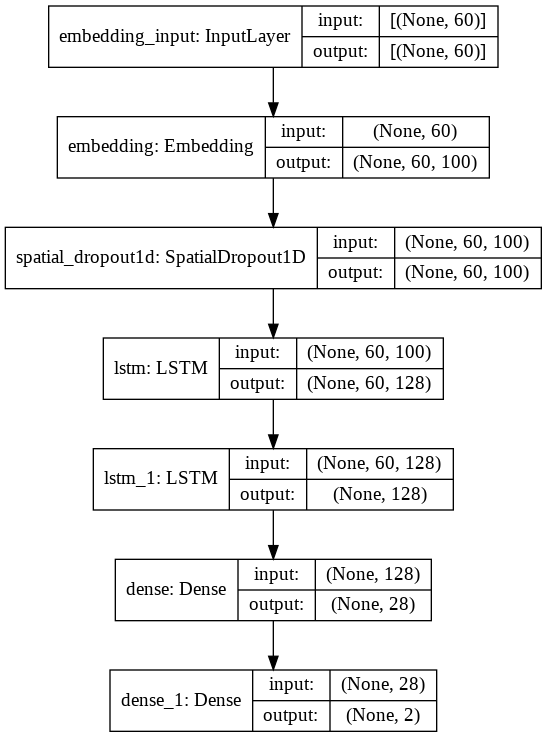

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.vis_utils import plot_model
filepath = path+"/model/LSTM.h5"
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.1, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.0001, cooldown=1, min_lr=0.000001)
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
callback_list = [acc_callback, checkpoint,reduceLROnPlat]

embedding_dim=100
LSTM_model = Sequential()
LSTM_model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))
LSTM_model.add(SpatialDropout1D(0.2))
LSTM_model.add(LSTM(128,return_sequences=True, recurrent_dropout=0.5))
LSTM_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
#LSTM_model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1))
LSTM_model.add(Dense(28, activation="relu"))
LSTM_model.add(Dense(num_category, activation='softmax'))
plot_model(LSTM_model, to_file= path+ '/model/model structure/LSTMmodel.png', show_shapes=True, show_layer_names=True)

In [ ]:
LSTM_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(LSTM_model.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 60, 100)           5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 60, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 128)           117248    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_7 (Dense)              (None, 28)                3612      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 58        
Total params: 5,252,502
Trainable params: 5,252,502
Non-trainable params: 0
____________________________________________

In [ ]:
num_epochs = 20
batch = 128

LSTM_history = LSTM_model.fit(train_padded, train_label_seq, 
                    epochs=num_epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, valid_label_seq), 
                    verbose=1,
                    callbacks = callback_list)


Epoch 1/20
312/312 [==============================] - 229s 717ms/step - loss: 0.5476 - accuracy: 0.6976 - val_loss: 0.3156 - val_accuracy: 0.8789

Epoch 00001: val_accuracy improved from -inf to 0.87890, saving model to /content/drive/MyDrive/Colab Notebooks/Suicide Ideation Detection using natural Language Processing/model/LSTM.h5
Epoch 2/20
312/312 [==============================] - 223s 716ms/step - loss: 0.2428 - accuracy: 0.9120 - val_loss: 0.2503 - val_accuracy: 0.9078

Epoch 00002: val_accuracy improved from 0.87890 to 0.90782, saving model to /content/drive/MyDrive/Colab Notebooks/Suicide Ideation Detection using natural Language Processing/model/LSTM.h5
Epoch 3/20
312/312 [==============================] - 224s 718ms/step - loss: 0.1881 - accuracy: 0.9363 - val_loss: 0.4162 - val_accuracy: 0.8310

Epoch 00003: val_accuracy did not improve from 0.90782
Epoch 4/20
312/312 [==============================] - 223s 714ms/step - loss: 0.1630 - accuracy: 0.9458 - val_loss: 0.2416 - va

In [ ]:
#make predictions

LSTM_model = load_model(path+"/model/LSTM.h5")
predictions = LSTM_model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)

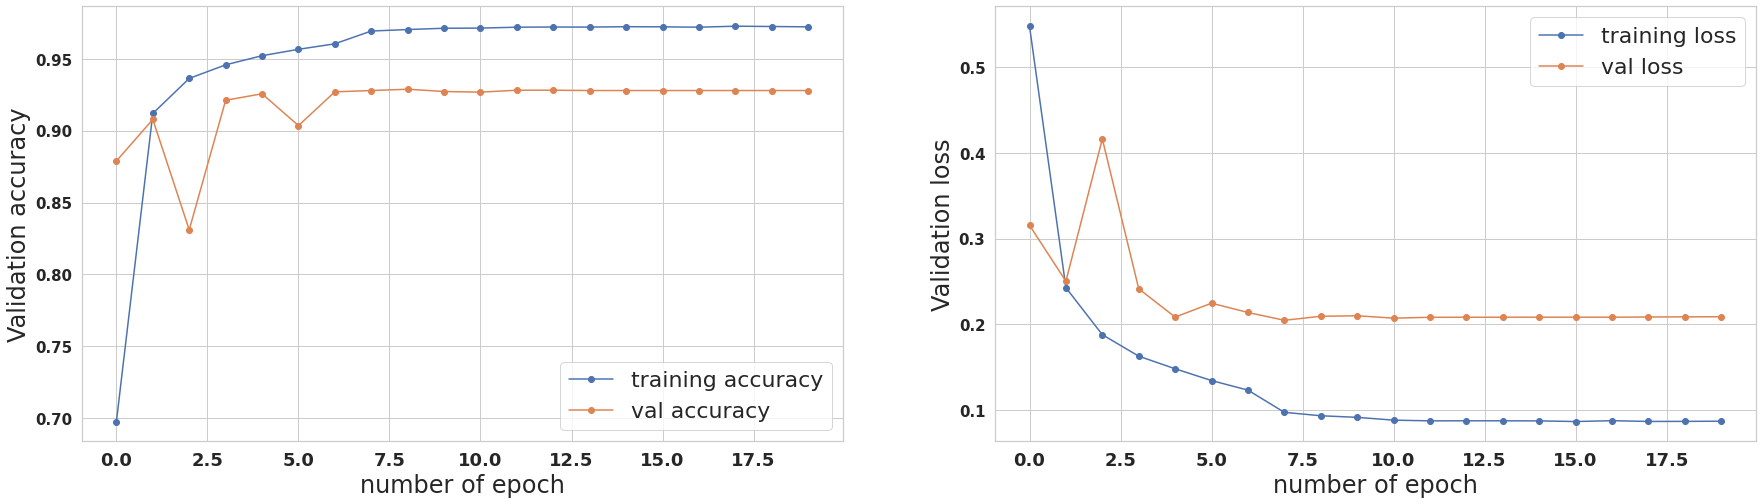

In [ ]:
# Plot training results
model_evaluate(LSTM_history,"LSTM","LSTM_evaluation")


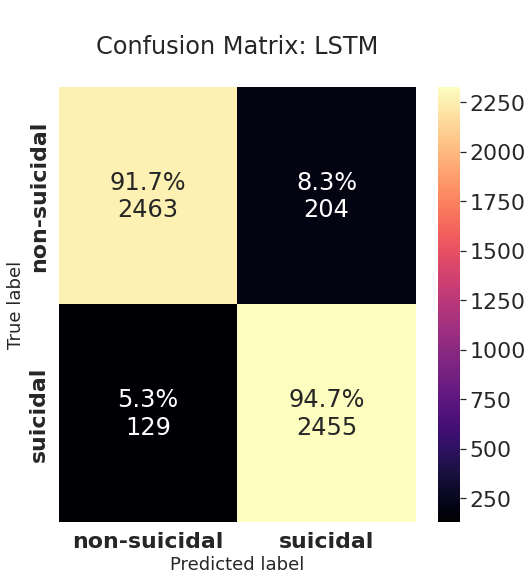

In [ ]:
conf_matrix(y_pred,"LSTM","LSTM","LSTM_confusion_matrix")

In [ ]:
#testing out
txt = ["I didn't want to wake up. I was having a much better time asleep."]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = LSTM_model.predict(padded)

labels = ['1', '0']
print(pred, labels[np.argmax(pred)])

[[0.85535425 0.14464577]] 1


**C-LSTM**

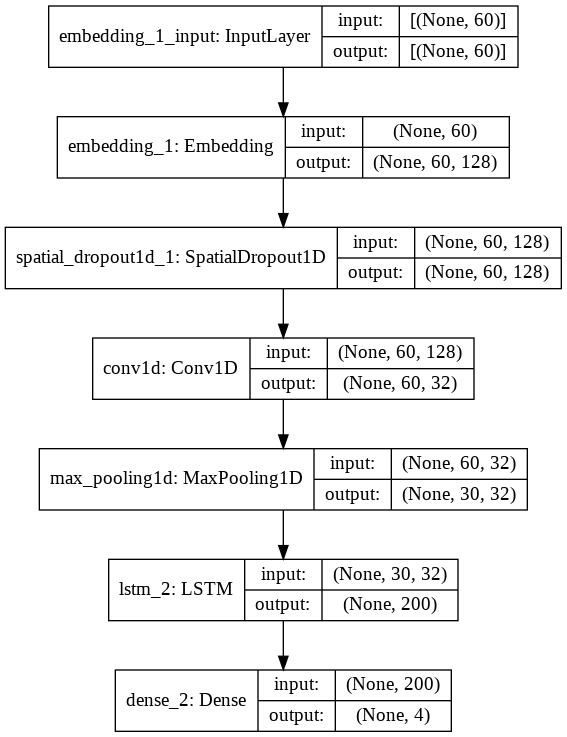

In [22]:
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

filepath = path+"/model/C-LSTM.h5"
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.1, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.0001, cooldown=1, min_lr=0.000001)
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
callback_list = [acc_callback, checkpoint,reduceLROnPlat]
embedding_dim=128
# create the model
C_LSTM_model = Sequential()
C_LSTM_model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))
C_LSTM_model.add(SpatialDropout1D(0.7))
C_LSTM_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
C_LSTM_model.add(MaxPooling1D(pool_size=2))
C_LSTM_model.add(LSTM(200, dropout=0.5, recurrent_dropout=0.5))
C_LSTM_model.add(Dense(4, activation='softmax'))
plot_model(C_LSTM_model, to_file= path+ '/model/model structure/C_LSTMmodel.png', show_shapes=True, show_layer_names=True)



In [23]:
C_LSTM_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(C_LSTM_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 128)           6400000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 60, 128)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 32)            12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               186400    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 804       
Total params: 6,599,524
Trainable params: 6,599,524
Non-trainable params: 0
____________________________________________

In [ ]:
num_epochs = 20
batch = 128

C_LSTM_history = C_LSTM_model.fit(train_padded, train_label_seq,
                           epochs=num_epochs,
                           batch_size = batch,
                           validation_data=(validation_padded,valid_label_seq),
                           verbose=1,
                           callbacks = callback_list)


Epoch 1/20
  7/312 [..............................] - ETA: 1:47 - loss: 1.0396 - accuracy: 0.4855

In [ ]:
#make predictions

C_LSTM_model = load_model(path+"/model/C-LSTM.h5")
predictions = C_LSTM_model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)

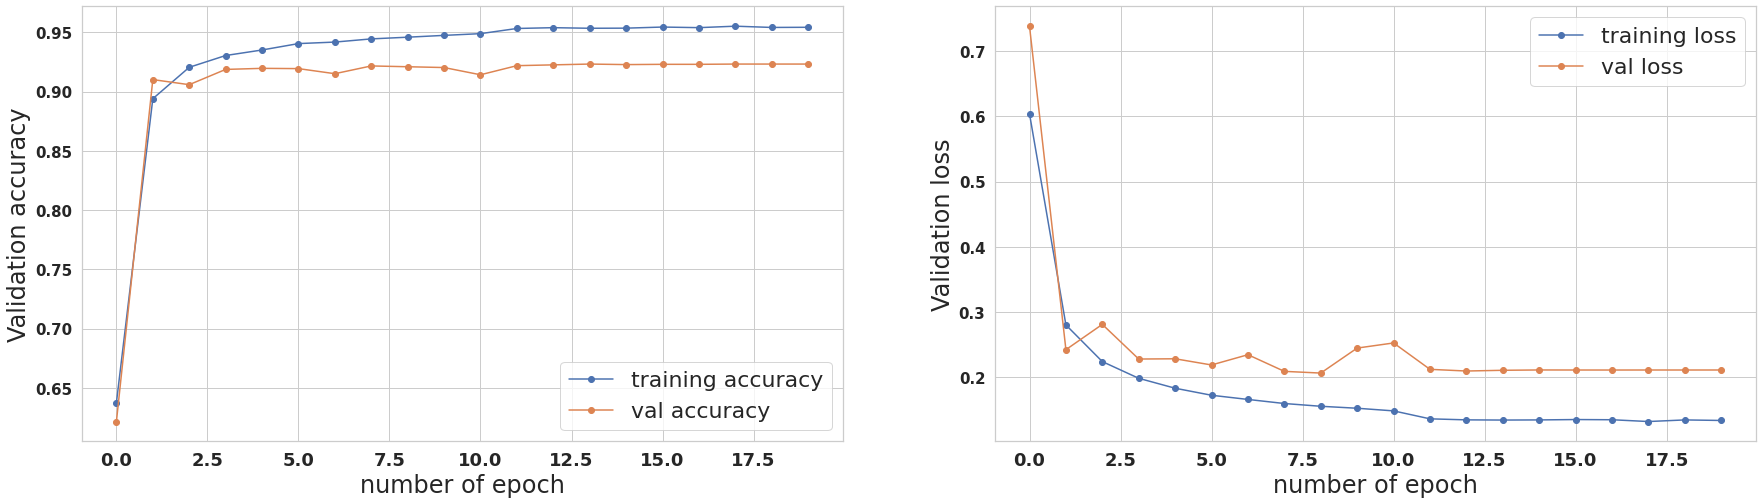

In [ ]:
# Plot training results
model_evaluate(C_LSTM_history,"C_LSTM","C_LSTM_evaluation")


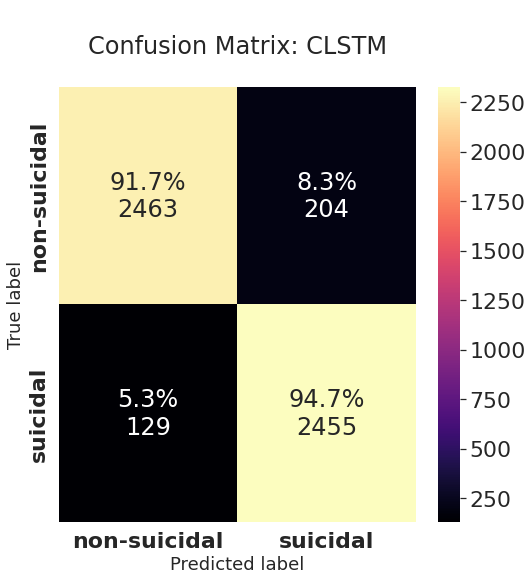

In [ ]:
conf_matrix(y_pred,"CLSTM","C_LSTM","C_LSTM_confusion_matrix")

**Result analysis**

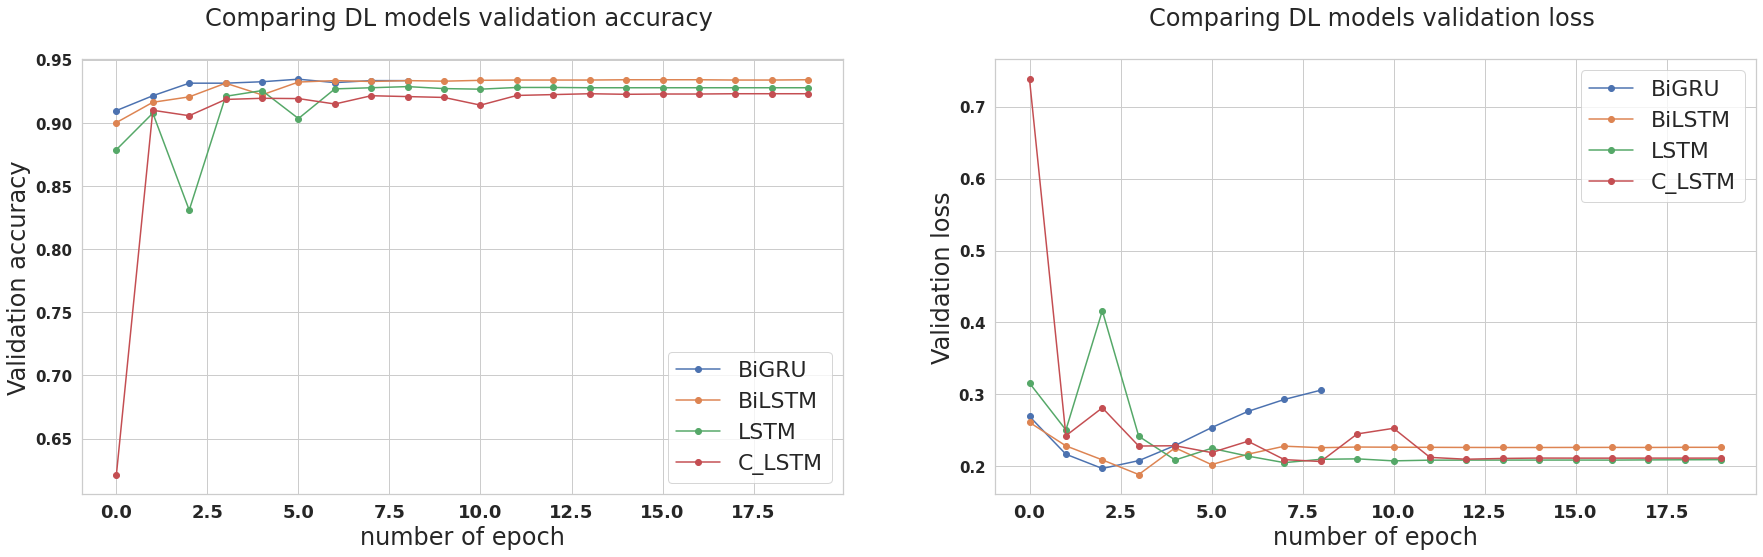

In [ ]:
model_all_evaluate(BGRU_model_history,RNN_history,LSTM_history,C_LSTM_history,"DL comparison","val_eva")

In [ ]:

MLA = {
     'Bidirectional GRU' : model,
     'Bidirectional LSTM' : RNN_model,
     'LSTM' : LSTM_model,
     'C_LSTM' : C_LSTM_model, 
}

In [ ]:
from sklearn.metrics import *
columns = []
compare = pd.DataFrame(columns = columns)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=2
row_index = 0
for name,alg in MLA.items():
    #fp, tp, th = roc_curve(y_test, predicted ,pos_label=['Political', 'acceptable', 'religious', 'sexual'])
    MLA_name = name
    #alg.fit(X_train, y_train)
    predicted = alg.predict(test_padded)
    y_pred = np.argmax(predicted, axis=1)
    auc_score = roc_auc_score(y_test, y_pred)
    micro_averaged_recall = recall_score(testing_label_seq, y_pred, average = 'micro')
    macro_averaged_f1 = f1_score(testing_label_seq, y_pred, average = 'macro')
    compare.loc[row_index,'Name'] = MLA_name
    compare.loc[row_index, 'Test Accuracy'] = accuracy_score(testing_label_seq,y_pred)
    compare.loc[row_index, 'Precision'] = precision_score(testing_label_seq, y_pred)
    compare.loc[row_index, 'Recall'] = micro_averaged_recall
    compare.loc[row_index, 'F1 Score'] = macro_averaged_f1
    compare.loc[row_index, 'auc Score'] = auc_score
    row_index+=1
    
compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
compare

,Name,Test Accuracy,Precision,Recall,F1 Score,auc Score
1,Bidirectional LSTM,0.936560,0.933630,0.936560,0.936559,0.936565
2,LSTM,0.935340,0.933821,0.935340,0.935340,0.935342
0,Bidirectional GRU,0.934933,0.939120,0.934933,0.934930,0.934925
3,C_LSTM,0.932290,0.919368,0.932290,0.932277,0.932314


In [ ]:
#plot comaparison 
def compare_plots(y_value,directory,filename):
  plt.subplots(figsize=(11,8))
  sn.barplot(x="Name", y=y_value ,data=compare,palette='hot',hue="Name",edgecolor=sn.color_palette('dark',7),dodge=False)
  plt.xlabel('DL Algorithms',fontsize=18)
  plt.ylabel(y_value,fontsize=18)
  plt.xticks( rotation=0, weight = 'bold', )
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.title('Comparing models with '+y_value+'.')
  plt.legend(loc = 2, bbox_to_anchor = (1,1))
  plt.savefig(path + "/model/"+directory+"/"+filename+".png")
  plt.show()
  return plt

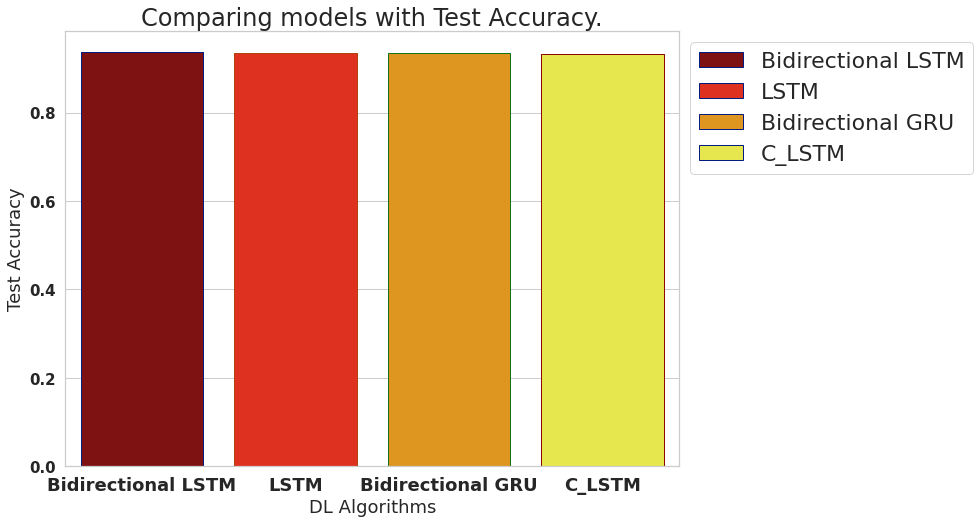

In [ ]:
test_comparison=compare_plots("Test Accuracy","DL comparison","test comparison")

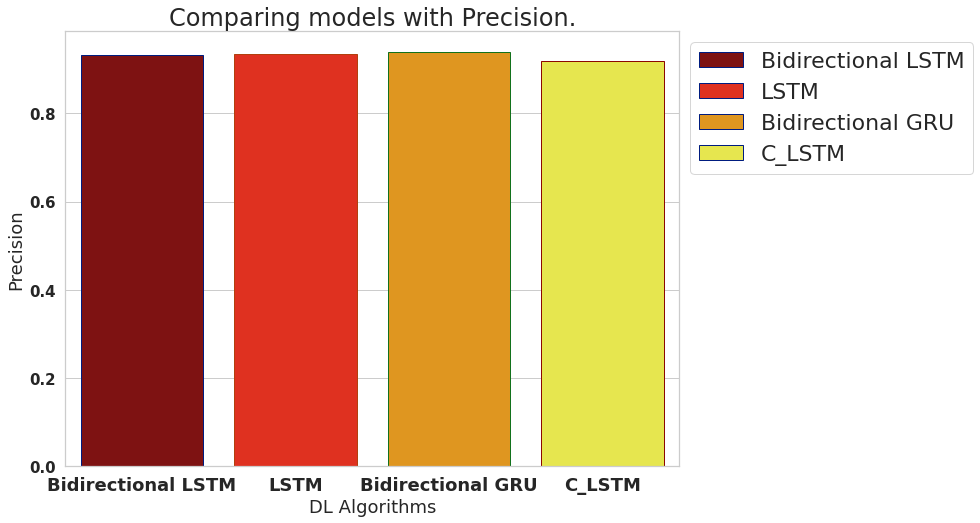

In [ ]:
Precision_comparison=compare_plots("Precision","DL comparison","Precision comparison")

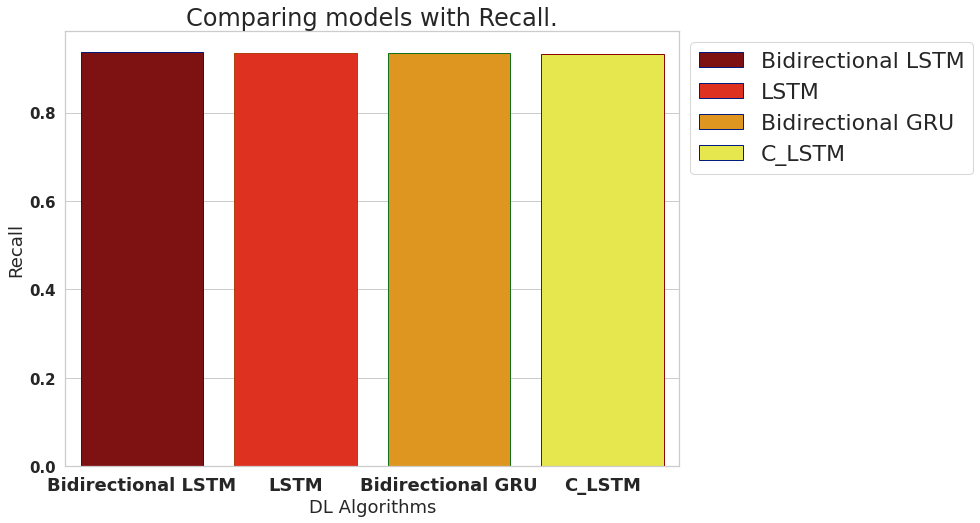

In [ ]:
Recall_comparison=compare_plots("Recall","DL comparison","Recall comparison")

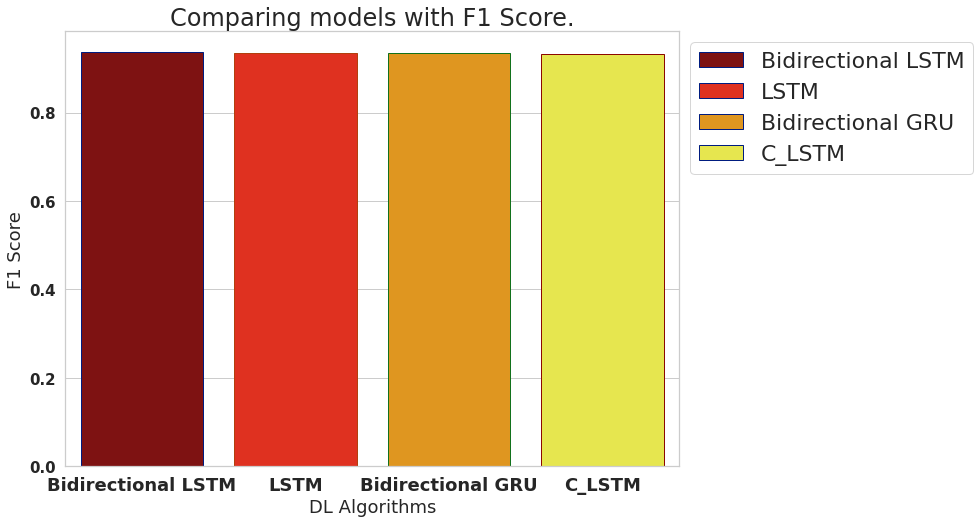

In [ ]:
F1_comparison=compare_plots("F1 Score","DL comparison","F1 Score comparison")

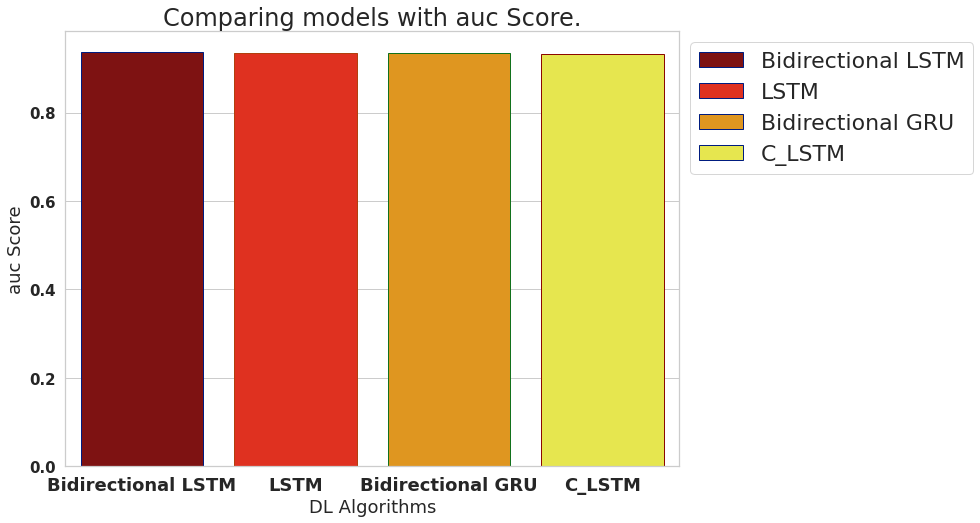

In [ ]:
auc_comparison=compare_plots("auc Score","DL comparison","auc Score comparison")

In [ ]:
compare.to_csv(path + '/dataset/created/dl_compare.csv', index=False)

In [ ]:
# plotly
!pip install chart-studio
from chart_studio import plotly as py
#import plotly.plotly as py
import plotly
import plotly.offline as pyo

from plotly.offline import init_notebook_mode, iplot,plot
init_notebook_mode()
import plotly.graph_objs as go
import plotly.figure_factory as ff # import figure factory

In [ ]:

# create trace3 
trace3 = go.Bar(
         x = np.array("C_LSTM"),
         y = np.array(compare[compare["Name"] == 'C_LSTM']['Test Accuracy']),
         name = "C_LSTM",
         marker = dict(color ='rgba(36, 44, 188, 1)',
         line=dict(color='rgb(0,0,0)',width=1))
                    )
# create trace4 
trace4 = go.Bar(
         x = np.array("Bidirectional LSTM"),
         y = np.array(compare[compare["Name"] == 'Bidirectional LSTM']['Test Accuracy']),
         name = "Bidirectional LSTM",
         marker = dict(color ='rgba(209, 0, 224, 1)',
         line=dict(color='rgb(0,0,0)',width=1))
                    )
# create trace5 
trace5 = go.Bar(
         x = np.array("Bidirectional GRU"),
         y = np.array(compare[compare["Name"] == 'Bidirectional GRU']['Test Accuracy']),
         name = "Bidirectional GRU",
         marker = dict(color ='rgba(0, 224, 209, 1)',
         line=dict(color='rgb(0,0,0)',width=1))
                    )
# create trace6 
trace6 = go.Bar(
         x = np.array("LSTM"),
         y = np.array(compare[compare["Name"] == 'LSTM']['Test Accuracy']),
         name = "LSTM",
         marker = dict(color ='rgba(255, 255, 61, 1)',
         line=dict(color='rgb(0,0,0)',width=1))
                    )

data = [trace4,trace6,trace3,trace5]
layout = go.Layout(barmode = "group",title="Deep Learning Classification Models test accuracy Comparison")
fig = go.Figure(data = data, layout = layout)
fig.show(renderer="colab")